# CLIP

CLIP (Contrastive Language–Image Pretraining) is a model developed by OpenAI that connects vision and language. It is trained on a large amount of publicly available internet text paired with images. The model learns to understand and generate meaningful representations from both images and text, making it capable of zero-shot transfer across a range of tasks.

### Environment: imports and device

In [1]:
# Imports
import torch
import clip
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from CLIP import classify

# device
device = "cpu"                                  # "cuda" if torch.cuda.is_available() else "cpu"

/home/andrea/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model load
In this notebook, we are using the `ViT-B/32` version of the CLIP model. ViT-B/32 stands for Vision Transformer Base with a patch size of 32. The Vision Transformer is a model architecture that treats an image as a sequence of patches and applies transformer layers to understand the image. The ‘Base’ version of the model has a balance between size and performance, making it a good choice for many applications. Other versions of the model include `ViT-L/14` which is larger and potentially more accurate but also more computationally intensive.

In [2]:
model, preprocess = clip.load("ViT-B/32", device=device)

## CIFAR-10
The CIFAR-10 dataset is a collection of images used for machine learning and computer vision research. The dataset contains `60,000` `32x32` `color` images in `10 classes`, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

In [3]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# PROMPT ENGINEERING
adjusted_labels = []
for label in labels:
    if label in ["bird", "cat", "deer", "frog"]:
        adjusted_labels.append(f'this image contains a {label}, not a dog.')
    else:
        adjusted_labels.append(f'this image contains a {label}.')

text = clip.tokenize(adjusted_labels).to(device)

# transform = transforms.Compose([
#     transforms.Resize((224, 224)), 
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

dataset_name = 'cifar10'

dataset = datasets.CIFAR10(
    root='../../data',
    train=False,
    download=True,
    transform=preprocess
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


## Classification

In [4]:
## Load if already classified
true_labels = np.load(f'results/true_labels-{dataset_name}.npy')
predicted_labels = np.load(f'results/pred_labels-{dataset_name}.npy')

In [5]:
## Labels Calculation
true_labels, predicted_labels = classify(model, text, dataloader, dataset_name)

# np.save('true_labels.npy', true_labels)
# np.save('predicted_labels.npy', predicted_labels)

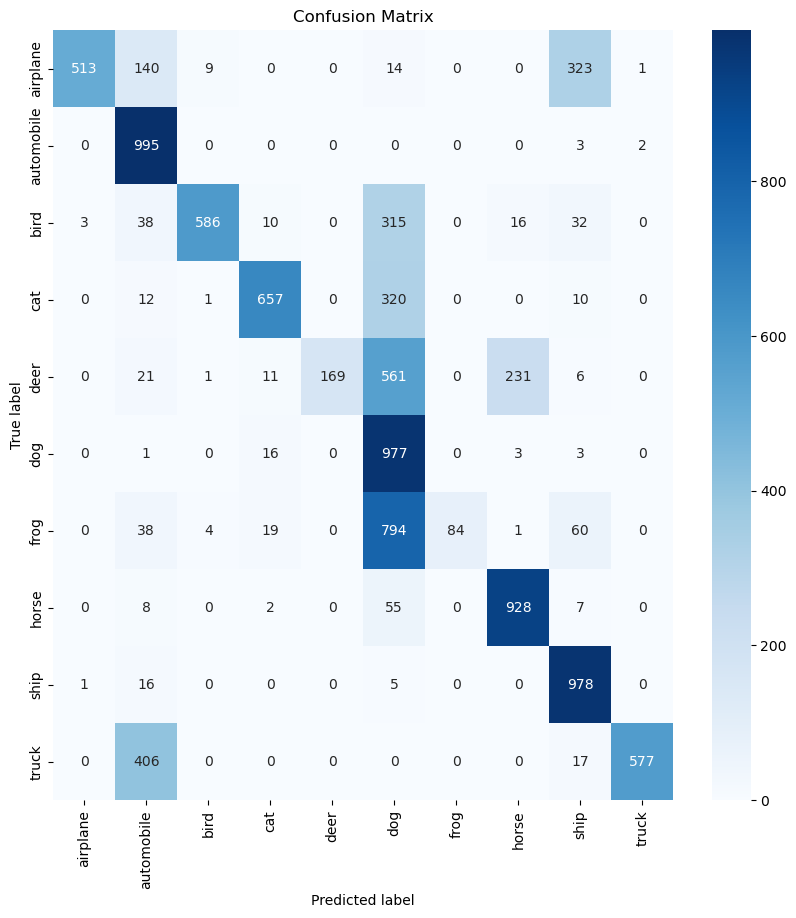

In [6]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
print(classification_report(true_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.98      0.81      0.89      1000
  automobile       0.65      0.99      0.78      1000
        bird       0.86      0.83      0.84      1000
         cat       0.77      0.83      0.80      1000
        deer       0.99      0.48      0.64      1000
         dog       0.54      0.93      0.69      1000
        frog       0.99      0.50      0.66      1000
       horse       0.80      0.94      0.87      1000
        ship       0.85      0.95      0.90      1000
       truck       0.99      0.58      0.73      1000

    accuracy                           0.79     10000
   macro avg       0.84      0.79      0.78     10000
weighted avg       0.84      0.79      0.78     10000

